# Importing Library

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf

# Checking GPU

In [12]:
gpus = tf.config.list_physical_devices('GPU')
print("Num GPUs Available: ", len(gpus))
if len(gpus) >= 1:
    tf.config.experimental.set_memory_growth(gpus[0], True)
else: 
    print(f'GPU not found, Using CPU for tensorflow')

Num GPUs Available:  1


# Loading the Image Data

In [16]:
# Define the path
folder_path = 'all_images/images_class/'

In [17]:
# Defining the constants
BATCH_SIZE = 32
IMG_HEIGHT = 32
IMG_WIDTH = 32

# Just for sake of testing sake we are loading the images

# Loading the set of  the images
train_ds = tf.keras.utils.image_dataset_from_directory(
  folder_path,
  seed=9,
  image_size=(IMG_HEIGHT, IMG_WIDTH))

Found 70 files belonging to 22 classes.


In [18]:
type(train_ds)

tensorflow.python.data.ops.dataset_ops.BatchDataset

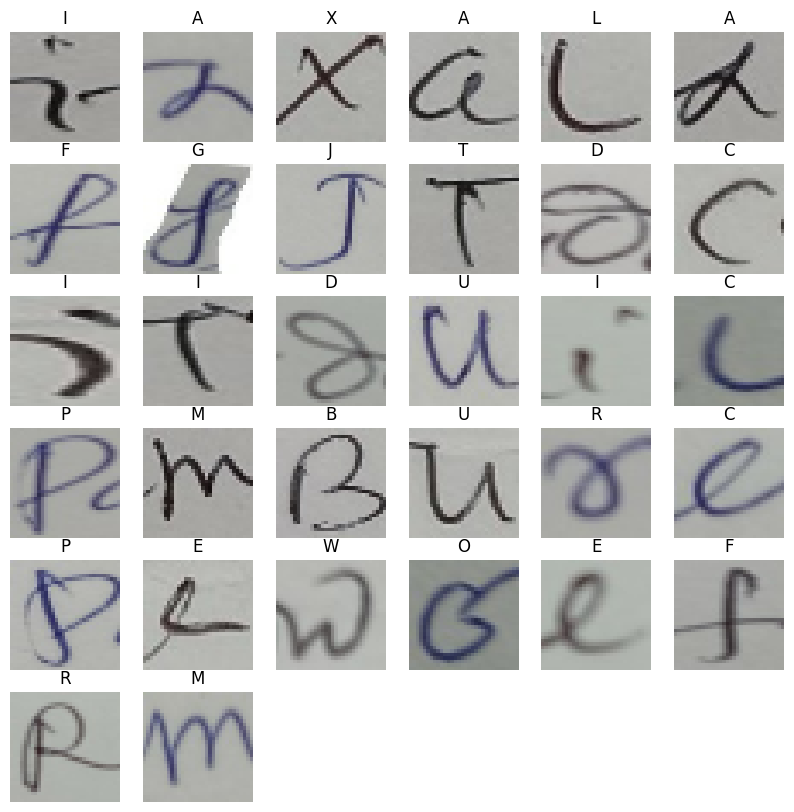

In [19]:
plt.figure(figsize=(10, 10))
class_names = train_ds.class_names
for images, labels in train_ds.take(1):
    for i in range(32):
        ax = plt.subplot(6, 6, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [28]:
del train_ds # For memory managment

# Image Augmentation

## Loading the library

In [8]:
import albumentations as A
import cv2

In [10]:
transform = A.Compose([A.RandomCrop(width=32, height=32), 
                         A.HorizontalFlip(p=0.5), 
                         A.RandomBrightnessContrast(p=0.2),
                         A.RandomGamma(p=0.2), 
                         A.RGBShift(p=0.2), 
                         A.VerticalFlip(p=0.5)])

## Image Augmentation Pipeline

In [26]:
import os # for accessing the files and creating the folder

if not os.path.exists('all_images/aug_images_class/'):
    os.makedirs('all_images/aug_images_class/')

for folder in os.listdir(folder_path):
    new_path = folder_path + folder + '/'
    image_numbering = [i for i in range(1,101)]
    image_num = 0
    
    if  not os.path.exists(f'all_images/aug_images_class/{folder}'):
        os.makedirs(f'all_images/aug_images_class/{folder}')

    aug_folder_path = f'all_images/aug_images_class/{folder}/'
    for image_path in os.listdir(new_path):
        image_path = new_path + image_path
        
        img = cv2.imread(image_path)
        img = cv2.resize(img, (32,32))
        
        for img_num in range(1, 101):
            aug_img = transform(image=img)['image']
            cv2.imwrite(aug_folder_path + f'{folder}_{img_num}.jpg', aug_img)



# Loading the Image Augmented Data

In [48]:
# Loading the set of  the images
aug_images_path = f'all_images/aug_images_class/'

train_ds = tf.keras.utils.image_dataset_from_directory(aug_images_path,
                                                       validation_split=0.2,
                                                       subset="training",
                                                       seed=9,
                                                       image_size=(IMG_HEIGHT, IMG_WIDTH),
                                                      label_mode='categorical',
                                                      labels='inferred')

val_ds = tf.keras.utils.image_dataset_from_directory(aug_images_path,
                                                       validation_split=0.2,
                                                       subset="validation",
                                                       seed=9,
                                                       image_size=(IMG_HEIGHT, IMG_WIDTH),
                                                    label_mode='categorical',
                                                      labels='inferred')

Found 2200 files belonging to 22 classes.
Using 1760 files for training.
Found 2200 files belonging to 22 classes.
Using 440 files for validation.


In [49]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Building Model

## Importing the library

In [92]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.layers import Dense, Dropout, Flatten, Rescaling, Input

from tensorflow.keras.optimizers import Adam

from tensorflow.keras import Sequential
from tensorflow.keras.models import Model

CLASS_COUNT = 22

def model_build():
    model =  Sequential()
    model.add(Input(shape=(32,32,3)))
    model.add(Rescaling(1./255))
    model.add(BatchNormalization())
    model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same'))
    model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same'))
    model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same'))
    model.add(MaxPooling2D(2,2))
    model.add(Conv2D(filters=128, kernel_size=(3,3), activation='relu', padding='same'))
    model.add(Conv2D(filters=128, kernel_size=(3,3), activation='relu', padding='same'))
    model.add(Conv2D(filters=128, kernel_size=(3,3), activation='relu', padding='same'))
    model.add(MaxPooling2D(2,2))
    model.add(Conv2D(filters=256, kernel_size=(3,3), activation='relu', padding='same'))
    model.add(Conv2D(filters=256, kernel_size=(3,3), activation='relu', padding='same'))
    model.add(Conv2D(filters=256, kernel_size=(3,3), activation='relu', padding='same'))
    model.add(MaxPooling2D(2,2))
    model.add(Conv2D(filters=512, kernel_size=(3,3), activation='relu', padding='same'))
    model.add(Conv2D(filters=512, kernel_size=(3,3), activation='relu', padding='same'))
    model.add(Conv2D(filters=512, kernel_size=(3,3), activation='relu', padding='same'))
    # model.add(GlobalAveragePooling2D())
    model.add(Flatten())
    model.add(Dense(units=440, activation='relu'))
    model.add(Dense(units=110, activation='relu'))
    model.add(Dense(units=CLASS_COUNT, activation='softmax'))
    
    return model

model = model_build()
model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_13 (Rescaling)    (None, 32, 32, 3)         0         
                                                                 
 batch_normalization_13 (Bat  (None, 32, 32, 3)        12        
 chNormalization)                                                
                                                                 
 conv2d_132 (Conv2D)         (None, 32, 32, 64)        1792      
                                                                 
 conv2d_133 (Conv2D)         (None, 32, 32, 64)        36928     
                                                                 
 conv2d_134 (Conv2D)         (None, 32, 32, 64)        36928     
                                                                 
 max_pooling2d_34 (MaxPoolin  (None, 16, 16, 64)       0         
 g2D)                                                

In [90]:
EPOCHS = 50
BATCH_SIZE = 32
LR = 1e-3
LEN_TRAIN = 1760
STEPS_PER_EPOCH = LEN_TRAIN // BATCH_SIZE

opt = Adam(learning_rate=LR, decay = LR / EPOCHS)

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath='DOCTOR_MODEL_1.h5',
    save_weights_only=False,
    monitor='val_loss',
    mode='min',
    save_best_only=True)

stopearly = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

tb = tf.keras.callbacks.TensorBoard(
    log_dir='./logs',
    histogram_freq=0,
    write_graph=True,
    write_images=False,
    write_steps_per_second=False,
    update_freq='epoch',
    profile_batch=0,
    embeddings_freq=0,
    embeddings_metadata=None)

callbacks = [model_checkpoint, stopearly, tb]

model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=opt)

In [91]:
history = model.fit(train_ds,
                    validation_data = val_ds,
                    batch_size = BATCH_SIZE,
                    steps_per_epoch=STEPS_PER_EPOCH,
                    epochs=EPOCHS,
                    verbose=1,
                    callbacks=callbacks)

Epoch 1/50
55/55 [==============================] - 5s 55ms/step - loss: 3.0946 - accuracy: 0.0318 - val_loss: 3.0916 - val_accuracy: 0.0432
Epoch 2/50
55/55 [==============================] - 2s 39ms/step - loss: 3.0914 - accuracy: 0.0460 - val_loss: 3.0923 - val_accuracy: 0.0273
Epoch 3/50
55/55 [==============================] - 2s 43ms/step - loss: 3.0912 - accuracy: 0.0500 - val_loss: 3.0929 - val_accuracy: 0.0273
Epoch 4/50
55/55 [==============================] - 3s 49ms/step - loss: 3.0911 - accuracy: 0.0500 - val_loss: 3.0935 - val_accuracy: 0.0273
Epoch 5/50
55/55 [==============================] - 2s 44ms/step - loss: 3.0910 - accuracy: 0.0500 - val_loss: 3.0939 - val_accuracy: 0.0273
Epoch 6/50
55/55 [==============================] - 2s 36ms/step - loss: 3.0909 - accuracy: 0.0500 - val_loss: 3.0944 - val_accuracy: 0.0273


## Using Tranfer learning

In [104]:
# to delete any previous model
if model:
    del model

In [105]:
resnet50v2 = tf.keras.applications.ResNet50V2(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=1000,
    classifier_activation="softmax",
)

# Set layer Trainable or not
for layer in resnet50v2.layers:
    layer.trainable = False

inputs = Input(shape=(32,32,3))
x = tf.keras.applications.resnet_v2.preprocess_input(inputs)
x = resnet50v2(x)
x = GlobalAveragePooling2D()(x)
# x = Dropout(0.5)(x)
# x = Dense(units)
outputs = Dense(units=CLASS_COUNT, activation='softmax')(x)

model = Model(inputs=inputs, outputs=outputs)

model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=opt)
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_24 (InputLayer)       [(None, 32, 32, 3)]       0         
                                                                 
 tf.math.truediv_3 (TFOpLamb  (None, 32, 32, 3)        0         
 da)                                                             
                                                                 
 tf.math.subtract_3 (TFOpLam  (None, 32, 32, 3)        0         
 bda)                                                            
                                                                 
 resnet50v2 (Functional)     (None, None, None, 2048)  23564800  
                                                                 
 global_average_pooling2d_10  (None, 2048)             0         
  (GlobalAveragePooling2D)                                       
                                                           

In [106]:
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath='DOCTOR_MODEL_RESNET50V2_1.h5',
    save_weights_only=False,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

stopearly = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

tb = tf.keras.callbacks.TensorBoard(
    log_dir='./logs',
    histogram_freq=0,
    write_graph=True,
    write_images=False,
    write_steps_per_second=False,
    update_freq='epoch',
    profile_batch=0,
    embeddings_freq=0,
    embeddings_metadata=None)

callbacks = [model_checkpoint, stopearly, tb]

In [107]:
history = model.fit(train_ds,
                    validation_data = val_ds,
                    batch_size = BATCH_SIZE,
                    steps_per_epoch=STEPS_PER_EPOCH,
                    epochs=EPOCHS,
                    verbose=1,
                    callbacks=callbacks)

Epoch 1/50
55/55 [==============================] - 6s 58ms/step - loss: 1.2226 - accuracy: 0.7426 - val_loss: 0.6024 - val_accuracy: 0.9455
Epoch 2/50
55/55 [==============================] - 3s 47ms/step - loss: 0.4292 - accuracy: 0.9699 - val_loss: 0.3955 - val_accuracy: 0.9705
Epoch 3/50
55/55 [==============================] - 2s 42ms/step - loss: 0.3026 - accuracy: 0.9795 - val_loss: 0.3103 - val_accuracy: 0.9773
Epoch 4/50
55/55 [==============================] - 3s 48ms/step - loss: 0.2397 - accuracy: 0.9818 - val_loss: 0.2607 - val_accuracy: 0.9795
Epoch 5/50
55/55 [==============================] - 2s 33ms/step - loss: 0.2003 - accuracy: 0.9835 - val_loss: 0.2274 - val_accuracy: 0.9795
Epoch 6/50
55/55 [==============================] - 2s 29ms/step - loss: 0.1728 - accuracy: 0.9864 - val_loss: 0.2033 - val_accuracy: 0.9795
Epoch 7/50
55/55 [==============================] - 2s 32ms/step - loss: 0.1522 - accuracy: 0.9886 - val_loss: 0.1850 - val_accuracy: 0.9818
Epoch 8/50
55

In [111]:
%load_ext tensorboard

# Tensor Board

In [108]:
%load_ext tensorboard

# Testing on New Images

In [7]:
# Pipeline to load new images for testing
def pred_word_from_image(path, word=False, model_path='DOCTOR_MODEL_RESNET50V2_1.h5'):
    #
    import tensorflow as tf
    import cv2
    import matplotlib.pyplot as plt
    import numpy as np
    #
    label_letter_dict = {0:'a', 1:'b', 2:'c', 3:'d', 4:'e',
                        5:'f', 6:'g', 7:'i', 8:'j', 9:'l',
                        10:'m', 11:'n', 12:'o', 13:'p', 14:'q',
                        15:'r', 16:'t', 17:'u', 18:'v', 19:'w',
                        20:'x', 21:'z'}
    #
    if word:
        pred_word = []
        for i in path:
            fig, ax = plt.subplots()
            img = cv2.imread(i, cv2.IMREAD_COLOR)
            img = cv2.resize(img, (32, 32), interpolation=cv2.INTER_AREA)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            #img = cv2.bitwise_not(img)
            plt.imshow(img, ax=ax)
            img = np.expand_dims(img, axis=0)
            print(img.shape)
            img = np.array(img, dtype="float32")
            # img /= 255.0
            model = tf.keras.models.load_model(model_path)
            pred = np.argmax(model.predict(img), axis=1)[0]
            pred_word.append(label_letter_dict[pred])
        plt.show()
        return pred_word
    else:
        img = cv2.imread(path, cv2.IMREAD_COLOR)
        img = cv2.resize(img, (32, 32), interpolation=cv2.INTER_AREA)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        # img = cv2.bitwise_not(img)
        plt.imshow(img)
        img = np.expand_dims(img, axis=0)
        img = np.array(img, dtype="float32")
        # img /= 255.0
        model = tf.keras.models.load_model(model_path)
        pred = np.argmax(model.predict(img), axis=1)
        pred_letter = label_letter_dict[pred[0]]
        return pred_letter, pred

1/1 [==============================] - 6s 6s/step


('b', array([1], dtype=int64))

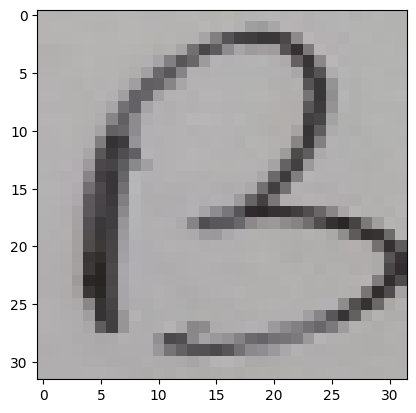

In [8]:
paths = ['all_images/test_images_original/img_001.jpg',
        'all_images/test_images_original/img_002.jpg',
        'all_images/test_images_original/img_003.jpg',
        'all_images/test_images_original/img_004.jpg',
        'all_images/test_images_original/img_005.jpg',
        'all_images/test_images_original/img_006.jpg',
        'all_images/test_images_original/img_007.jpg']

a_path = 'all_images/Cropped_Images/B_002.jpg'

pred_word_from_image(a_path, word=False)